In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")

## Price for discrete down-and-out barrier call:

The cell below defines classes for the underlying asset and a down-and-out call barrier option as well as a `calc_optionprices`-function for MC-simulations.

The `calc_optionprices`-function just takes a number of simulations and a class that implements a `payoff`-function, so in order to price other options, just implement the corresponding class.

In [2]:
class asset():
    """Class for underlyings"""
    def __init__(self, S0, mu, sigma, jumps=0):
        self.S0 = S0
        self.mu = mu
        self.sigma = sigma
        self.jumps = jumps

    def __repr__(self):
        varstring = ', '.join(f"{k} = {v}" for k, v in self.__dict__.items())
        return f"{self.__class__.__name__}({varstring})"
    

class barrier_option():
    """Base-class for barrier options"""
    def __init__(self, strike, barrier, timeline, underlying):
        self.K = strike
        self.timeline = np.array(timeline)
        self.B = barrier
        self.underlying = underlying

    def __repr__(self):
        return f"{self.__class__.__name__}(K = {self.K}, T = {self.T}, B = {self.B})"

    def __str__(self):
        return self.__repr__()


class barrier_discrete_downandout(barrier_option):
    def payoff(self, S):
        """Calculates and returns payoff given a matrix with underlying prices"""
        max = np.maximum
        
        # Calculate intrinsic value
        P = max(S[:, -1] - self.K, 0)
        # Zero payoff if barrier was hit
        P *= np.min(S - self.B, axis = 1) > 0

        return P


def calc_optionprices(n, option):
    """
    Approximates optionprices for the option specified in the option argument using MC-simulations.

    Args:
        n (int): number of simulations in MC-simulations
        option: instance of an option-class
    
    Returns:
        (tuple[float, numpy.array]): 
            A tuple with calculated option price and statematrix
    """
    S0 = option.underlying.S0
    mu = option.underlying.mu
    sigma = option.underlying.sigma
    jumps = option.underlying.jumps

    timeline = option.timeline
    # Timedifference in the timeline is called dt
    dt = np.diff(timeline, prepend = 0)
    T = timeline[-1]
    
    # Generate random numbers
    Z = np.random.normal(0, 1, size = (n, len(timeline))) 
    
    # Calculate state matrix
    d1 = mu - (sigma**2) / 2
    d2 = d1*dt + sigma*np.sqrt(dt)*Z
    S = np.hstack([S0 * np.ones((n, 1)), np.exp(d2)]).cumprod(axis = 1)

    # Include jumps. This step is quite complicated as the jumps has to render the values after the jump
    # as if it was already there when the values was calculated. Open for suggestions here.
    # If `jumps` are zero this step does nothing
    S[:, 1:] += (np.hstack([np.exp(d2[:, 1:].cumsum(axis=1)), np.ones((n, 1))]) * jumps).cumsum(axis=1)

    # Calculate payoff with the payoff-method of the corresponding option
    P = option.payoff(S)

    # Apply time-zero discounting
    V = np.exp(-mu*T) * P
    
    # Calculate the MC-estimate
    V = np.sum(V)/n

    return (V, S)

## Equity value calculated with a discrete barrier on a process with discrete jumps

The `timeline`-array determines for which days MC should simulate values of the underlying. Time 0 are included automatically. 

The jumps in the `jumps`-array must fall on the dates specified in the `timeline`-array. If you want more steps in the simulation than there are jumps (e.g. for plotting) just set the corresponding jump size to zero (like in the example below). More steps does not give a better approximation though, as the transition probability is known and the step-size can be arbitrarily large without loss of precision. (Unless of course you are evaluating a continuous barrier option, but that is not the case here.)

Below are the example with to payments at time 1 and time 2 each with a principal of 50:

In [3]:
timeline = np.array([0.5, 1, 1.5, 2])
jumps = np.array([0, -50, 0, -50])

# Define the underlying, i.e. the firm value
underlying = asset(S0=130, mu=0.01, sigma=0.25, jumps=jumps)
# Define the option
equity = barrier_discrete_downandout(strike=0, barrier=0, timeline=timeline, underlying=underlying)

# Calculate prices with MC-simulations
equity_value, states = calc_optionprices(n=100000, option=equity)
print(f"Equity value: {equity_value}")

Equity value: 34.26216296126977


## Plot of states
You should probably not run the cell below with >100 simulations. Remark that the jumps are not visible per se as they are embedded in the values.

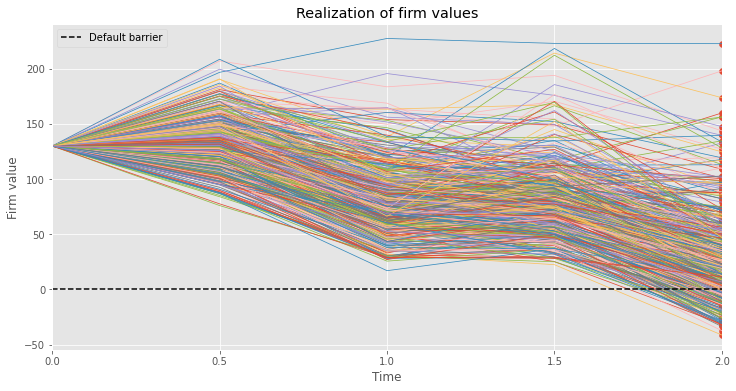

In [9]:
equity_value, states = calc_optionprices(n=500, option=equity)
x = np.hstack([0, timeline])
fig, ax = plt.subplots(1, figsize=(12,6))
ax.plot(x, states.T, linewidth=0.75) 
ax.scatter(np.repeat(timeline[-1], states.shape[0]), states[:,-1])
ax.plot((0, timeline[-1]), (0, 0), label="Default barrier", color="black", linestyle="--")

ax.legend()

ax.set_xlim((0, timeline[-1]))
ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(x))
ax.set_xlabel("Time")
ax.set_ylabel("Firm value")
ax.set_title("Realization of firm values")

plt.show()